## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as skio
import matplotlib.patches as mpatches

import os
import random
import json
import scipy.stats as stats
from collections import defaultdict
import tqdm

import sklearn.preprocessing
import sklearn.model_selection
import sklearn.pipeline 
import sklearn.linear_model
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import warnings
warnings.filterwarnings(action='ignore',category=sklearn.exceptions.ConvergenceWarning)

## Dataset

In [2]:
metadata = pd.read_csv("dataset/metadata.csv")
metadata

,PATIENT_ID,MEASUREMENT_DATE,HB_LEVEL_GperL,NAIL_BOUNDING_BOXES,SKIN_BOUNDING_BOXES
0,1,14b0293a34344cc4fba0fa39d5370c52,134.0,"[[251, 447, 302, 505], [123, 429, 183, 483], [...","[[267, 586, 324, 627], [148, 556, 200, 614], [..."
1,2,14b0293a34344cc4fba0fa39d5370c52,108.0,"[[236, 503, 281, 556], [148, 457, 195, 514], [...","[[252, 612, 294, 647], [162, 585, 212, 632], [..."
2,5,14b0293a34344cc4fba0fa39d5370c52,84.0,"[[244, 508, 277, 562], [183, 448, 220, 505], [...","[[264, 629, 303, 662], [193, 584, 232, 619], [..."
3,6,14b0293a34344cc4fba0fa39d5370c52,138.0,"[[311, 456, 363, 521], [182, 408, 237, 471], [...","[[318, 609, 380, 650], [189, 562, 245, 616], [..."
4,7,14b0293a34344cc4fba0fa39d5370c52,119.0,"[[29, 513, 78, 556], [119, 435, 165, 479], [18...","[[29, 635, 79, 678], [117, 564, 175, 615], [20..."
...,...,...,...,...,...
245,337,358202da91d3949be1611c0f898eb858,142.0,"[[277, 479, 327, 548], [208, 392, 269, 460], [...","[[283, 612, 344, 669], [197, 532, 251, 620], [..."
246,339,358202da91d3949be1611c0f898eb858,139.0,"[[283, 497, 336, 553], [208, 429, 257, 493], [...","[[279, 615, 328, 684], [189, 571, 248, 643], [..."
247,340,358202da91d3949be1611c0f898eb858,122.0,"[[321, 515, 371, 579], [264, 475, 315, 533], [...","[[305, 639, 353, 691], [228, 603, 281, 663], [..."
248,341,358202da91d3949be1611c0f898eb858,50.0,"[[356, 553, 413, 607], [279, 485, 335, 536], [...","[[337, 669, 387, 713], [253, 612, 297, 661], [..."


In [3]:
metadata['NAIL_BOUNDING_BOXES'] = metadata['NAIL_BOUNDING_BOXES'].apply(json.loads)
metadata['SKIN_BOUNDING_BOXES'] = metadata['SKIN_BOUNDING_BOXES'].apply(json.loads)

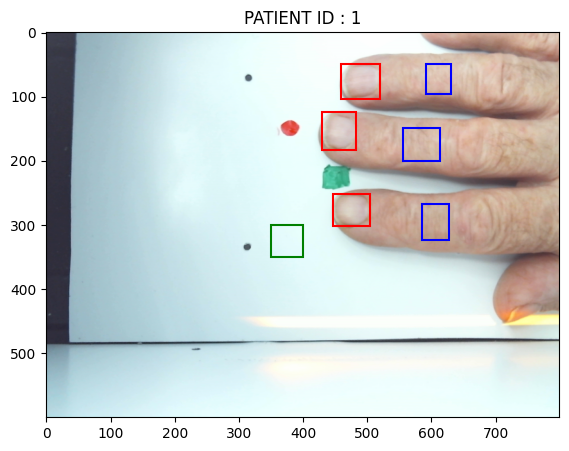

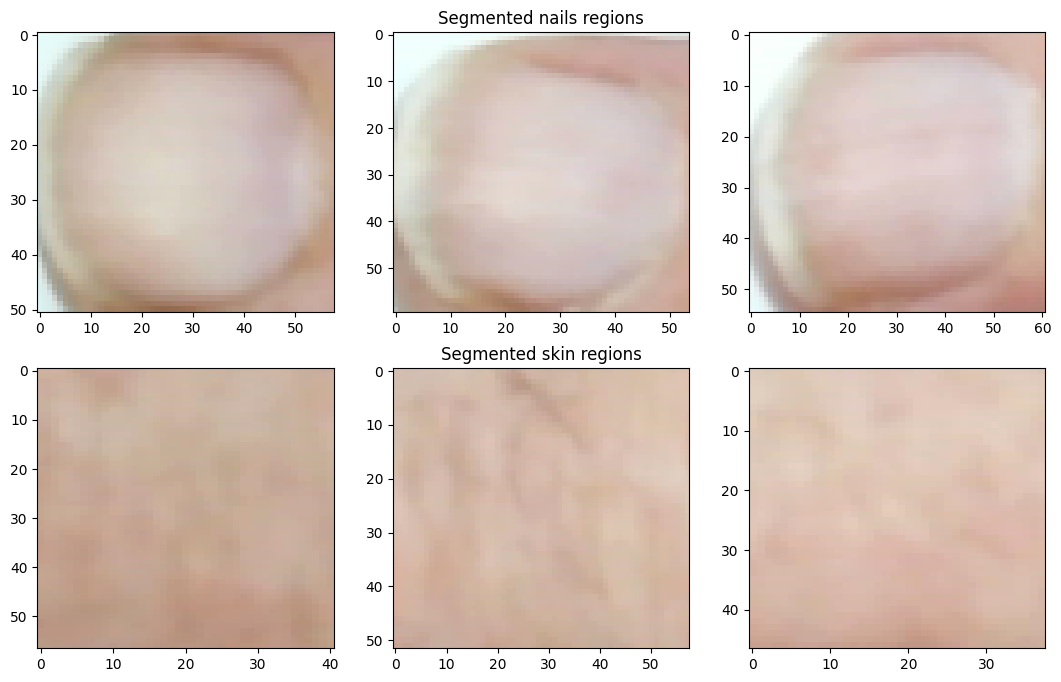

In [4]:
image_folder = "dataset/photo"
N_MAX_IMAGES = 1

for j,(_, row) in enumerate(metadata.iterrows()):
    
    if j ==  N_MAX_IMAGES:
        break
    
    img_path = os.path.join(image_folder,f'{row.PATIENT_ID}.jpg')
    
    img = skio.imread(img_path)
    
    plt.figure(figsize=(7,5))
    plt.imshow(img)
    
    nails_bboxes = row.NAIL_BOUNDING_BOXES
    skin_bboxes  = row.SKIN_BOUNDING_BOXES
    
    ax = plt.gca()
    
    for _color,_bboxes in zip(['r','b'],[nails_bboxes,skin_bboxes]):
        for top,left,bot,right in _bboxes:
            
            w,h = right-left,bot-top
            
            rectangle = mpatches.Rectangle(xy=(left,top),width=w,height=h,fill=None,
                                           color=_color,linewidth=1.5)
            
            ax.add_patch(rectangle)
            
    white_region_rectangle = mpatches.Rectangle(xy=(350,300),width=50,height=50,fill=None,
                                           color='green',linewidth=1.5)
    ax.add_patch(white_region_rectangle)
    
    plt.title(f"PATIENT ID : {row.PATIENT_ID}")
    
    fig,axs = plt.subplots(2,3,figsize=(13,8))
    axs = axs.ravel()
    
    all_bboxes = nails_bboxes + skin_bboxes
    
    for i,(top,left,bot,right) in enumerate(all_bboxes):
        axs[i].imshow(img[top:bot,left:right],aspect='auto')
        if i == 1:
            axs[i].set_title("Segmented nails regions")
        if i == 4:
            axs[i].set_title("Segmented skin regions")
        
    plt.show()

In [5]:
metadata["NAIL_BOUNDING_BOXES"].apply(len).value_counts()

NAIL_BOUNDING_BOXES
3    250
Name: count, dtype: int64

In [6]:
metadata["SKIN_BOUNDING_BOXES"].apply(len).value_counts()

SKIN_BOUNDING_BOXES
3    250
Name: count, dtype: int64

In [7]:
N_FINGERS = 3

In [8]:
row

PATIENT_ID                                                             2
MEASUREMENT_DATE                        14b0293a34344cc4fba0fa39d5370c52
HB_LEVEL_GperL                                                     108.0
NAIL_BOUNDING_BOXES    [[236, 503, 281, 556], [148, 457, 195, 514], [...
SKIN_BOUNDING_BOXES    [[252, 612, 294, 647], [162, 585, 212, 632], [...
Name: 1, dtype: object

## Image Preprocessing

In [9]:
class HandImageDataset(Dataset):
    def __init__(self, metadata, image_folder, tissue_type="NAIL", finger_index=None, image_size=(64, 64)):
        self.image_folder = image_folder
        self.image_data = dict()
        self.metadata = metadata
        self.patient_ids = list(metadata["PATIENT_ID"])

        self.tissue_type = tissue_type
        self.finger_index = finger_index

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(image_size),
        ])
        
        # Preprocess metadata to extract and store image crops
        for _, row in tqdm.tqdm(metadata.iterrows(), total=len(metadata)):
            patient_id = row["PATIENT_ID"]
            img_path = os.path.join(self.image_folder, f"{patient_id}.jpg")
            img = skio.imread(img_path)
            
            nails_bboxes = row["NAIL_BOUNDING_BOXES"]
            skin_bboxes = row["SKIN_BOUNDING_BOXES"]

            self.image_data[patient_id] = defaultdict(list)
            
            for tissue, bboxes in zip(["NAIL", "SKIN"], [nails_bboxes, skin_bboxes]):
                for finger_num, (top, left, bot, right) in enumerate(bboxes, start=1):
                    selected_region = img[top:bot, left:right]
                    
                    self.image_data[patient_id][tissue].append(selected_region)
            
            self.image_data[patient_id]["WHITE_REF"].append(img[350:400, 300:350])
            self.image_data[patient_id]["target"] = row["HB_LEVEL_GperL"]
        

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, index):
        patient_id = self.patient_ids[index]
        image_data = self.image_data[patient_id]
        
        tissue_regions = image_data[self.tissue_type]

        # Handle finger index selection
        if self.finger_index is not None and (0 <= self.finger_index < N_FINGERS):
            selected_image = tissue_regions[self.finger_index]
        else:
            # Randomly select a finger
            selected_image = random.choice(tissue_regions)

        # Apply resizing
        selected_image = self.transform(selected_image)

        # Target value
        target = image_data["target"]

        return selected_image, torch.tensor(target, dtype=torch.float32)

In [10]:
dataset = HandImageDataset(metadata, image_folder)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:13<00:00, 18.53it/s]


In [11]:
def show_patient_data(dataset, idx):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13,8))

    patient_id = dataset.patient_ids[idx]
    
    for i, img in enumerate(dataset.image_data[patient_id]["NAIL"]):
        axes[0, i].imshow(img, aspect="auto")

    for i, img in enumerate(dataset.image_data[patient_id]["SKIN"]):
        axes[1, i].imshow(img, aspect="auto")

    axes[0, 1].set_title("Segmented nails regions")
    axes[1, 1].set_title("Segmented skin regions")

    fig.suptitle(f"Data point #{idx}")
    plt.show()

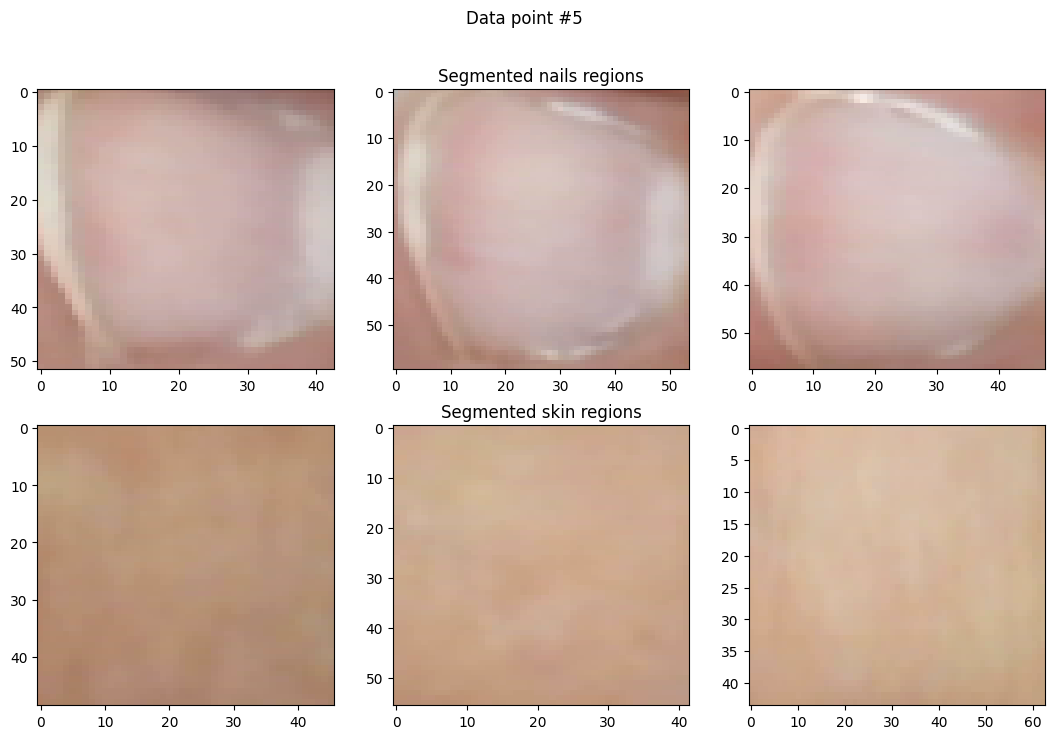

In [12]:
show_patient_data(dataset, 5)

In [13]:
class HandImageDataLoader:
    def __init__(self, dataset, tissue_type="NAIL", finger_index=None, image_size=(64, 64)):
        """
        Custom DataLoader for Hand Image Dataset with tissue type and finger selection.
        
        Arguments
        ---------
            dataset (HandImageDataset): Predefined dataset.
            tissue_type (str): Tissue type to filter ("SKIN" or "NAIL").
            finger_index (int or None): Specific finger index (1-5) or None for random.
            target_size (tuple): Target size for resizing images (height, width).
        """
        self.dataset = dataset
        self.tissue_type = tissue_type.upper()
        self.finger_index = finger_index
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(target_size),
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Fetch patient data
        patient_data = self.dataset[index]
        patient_id = self.dataset.patient_ids[index]

        tissue_regions = patient_data[self.tissue_type]

        # Handle finger index selection
        if self.finger_index is not None and (0 <= self.finger_index < N_FINGERS):
            selected_image = tissue_regions[self.finger_index]
        else:
            # Randomly select a finger
            selected_image = random.choice(tissue_regions)

        # Apply resizing
        selected_image = self.transform(selected_image)

        # Target value
        target = patient_data["target"]

        return selected_image, torch.tensor(target, dtype=torch.float32)

## Train-test split

In [15]:
train_indices, test_indices = train_test_split(np.arange(len(dataset)),
                                               test_size=1/3, random_state=42)

In [16]:
len(train_indices)

166

In [17]:
len(test_indices)

84